**Outline**
1. Loading Data
2. Data Sanity Check: ensure consistent values across features
3. EDA, Insights & Recommendations: find patterns and provide actionable insights out of the data.
4. Data Cleansing: cast `TotalCharges` to float while dropping few rows with missing values.
5. Feature Engineering : convert categorical variables to dummy variables
6. Split Training and Test Set: provide hold-out test set to test model performance.
7. Plot Features Correlation: remove highly correlated features if any
8. Model Selection: select the best algorith
9. Hyperparameter finetuning: use RandomizedSearchCV to find best model hyperparameter
10. Predict Hold-out Test Set

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import warnings;warnings.filterwarnings("ignore")

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


## Loading Data

In [2]:
df = pd.read_csv('../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
df.shape

(7043, 21)

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.count()

customerID          7043
gender              7043
SeniorCitizen       7043
Partner             7043
Dependents          7043
tenure              7043
PhoneService        7043
MultipleLines       7043
InternetService     7043
OnlineSecurity      7043
OnlineBackup        7043
DeviceProtection    7043
TechSupport         7043
StreamingTV         7043
StreamingMovies     7043
Contract            7043
PaperlessBilling    7043
PaymentMethod       7043
MonthlyCharges      7043
TotalCharges        7043
Churn               7043
dtype: int64

In [6]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [7]:
for col in df.columns.to_list():
    print(df[col].value_counts())
    print()

6888-SBYAI    1
2845-HSJCY    1
5233-AOZUF    1
8182-PNAGI    1
8180-AKMJV    1
             ..
2995-YWTCD    1
4625-LAMOB    1
7321-PKUYW    1
5494-WOZRZ    1
1866-ZSLJM    1
Name: customerID, Length: 7043, dtype: int64

Male      3555
Female    3488
Name: gender, dtype: int64

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

No     3641
Yes    3402
Name: Partner, dtype: int64

No     4933
Yes    2110
Name: Dependents, dtype: int64

1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: tenure, Length: 73, dtype: int64

Yes    6361
No      682
Name: PhoneService, dtype: int64

No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64

Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64

No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64

No                   

## Data Sanity Check

In [8]:
# No phone service
df[df.PhoneService=='No'].MultipleLines.value_counts()

No phone service    682
Name: MultipleLines, dtype: int64

In [9]:
# No internet service
for col in ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']:
    print(df[df.InternetService=='No'][col].value_counts())
    print

No internet service    1526
Name: OnlineSecurity, dtype: int64
No internet service    1526
Name: OnlineBackup, dtype: int64
No internet service    1526
Name: DeviceProtection, dtype: int64
No internet service    1526
Name: TechSupport, dtype: int64
No internet service    1526
Name: StreamingTV, dtype: int64
No internet service    1526
Name: StreamingMovies, dtype: int64


Data looks good for no phone service and no internet service.

## EDA, Insights & Recommendations

In [10]:
df.Churn.value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [11]:
df.columns.to_list()

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

In [12]:
num_feature = ['tenure','MonthlyCharges'] #TotalCharges is processed separately since the data is not stored in float type
cat_feature = ['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

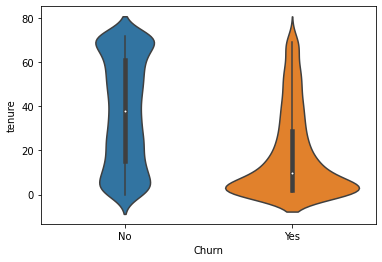

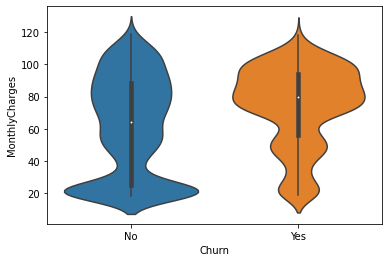

In [13]:
for col in num_feature:
    sns.violinplot(x='Churn',y=col,data=df)
    plt.show()

**Insights**:
1. `Tenure` of churned customers is skewed to short tenure duration and relatively shorter to non-churn customers, whereas the tenure of non-churn customers is more uniformly distributed. This makes sense since customer will be early to churn if they feel the product is not right fit for them and they will churn in their early customer lifecycle.
2. Interestingly, `MonthlyCharges` of churn customers are relatively higher than non-churn customers'. It means the churn customers use "more" services hence they are charged more. We should analyze later the differences on used services between churn and non-churn customers.

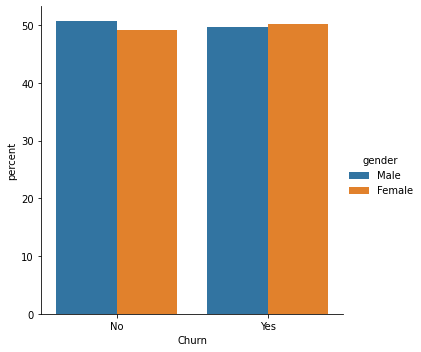

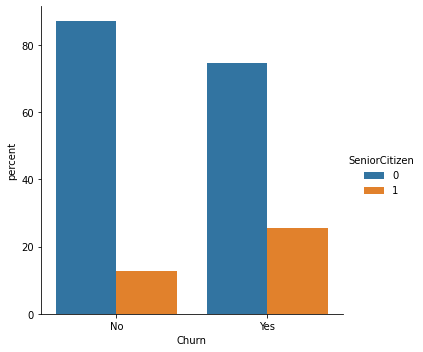

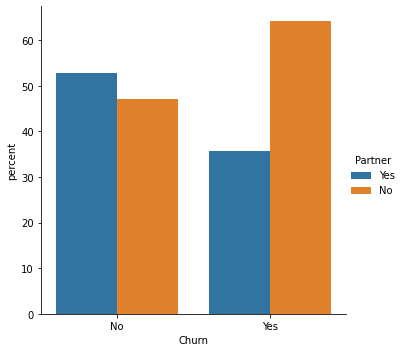

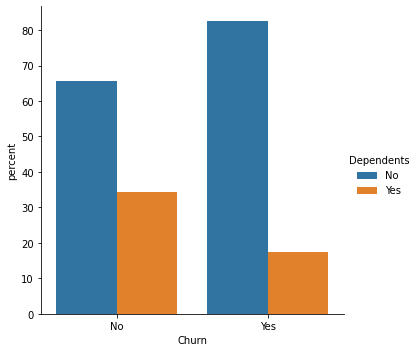

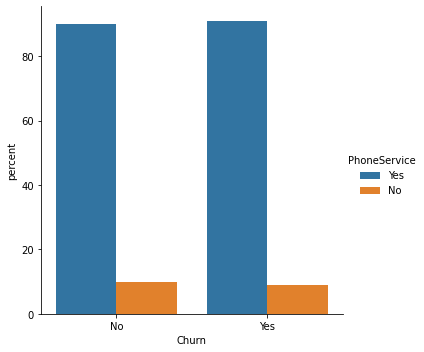

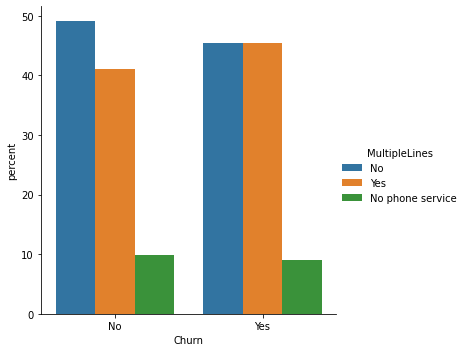

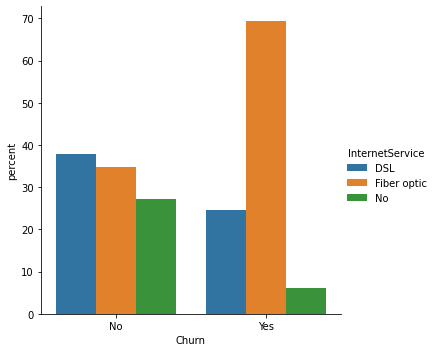

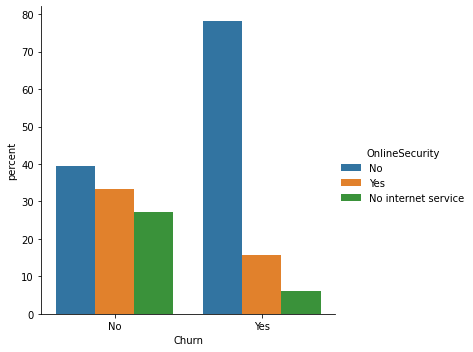

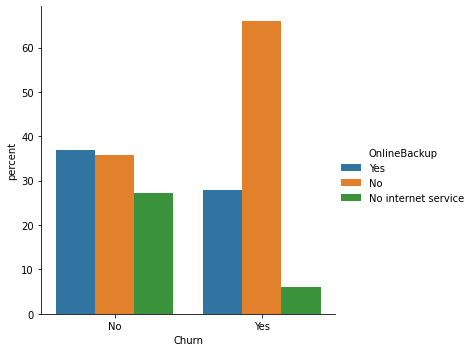

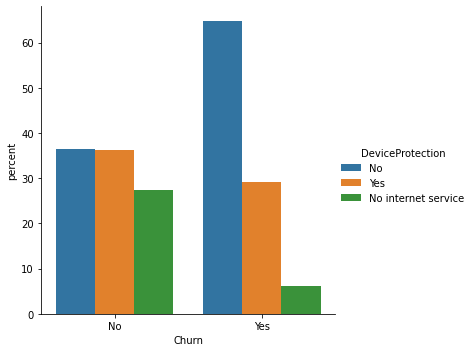

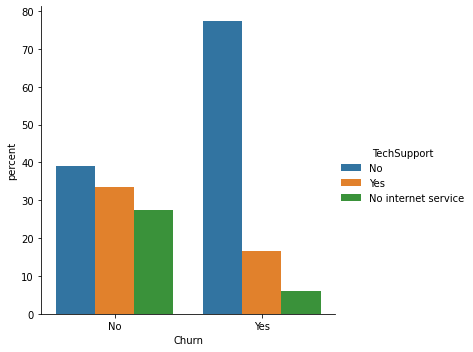

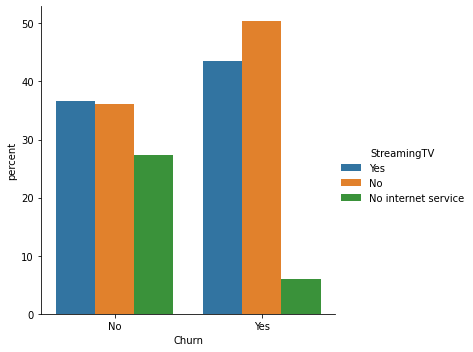

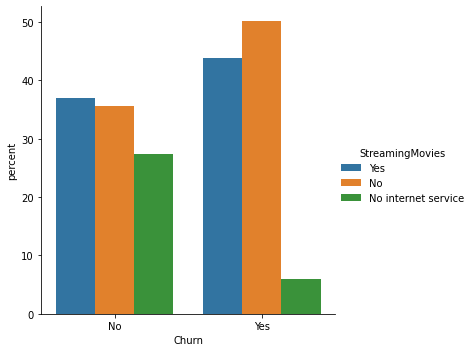

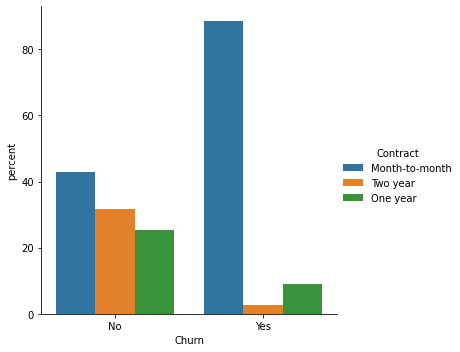

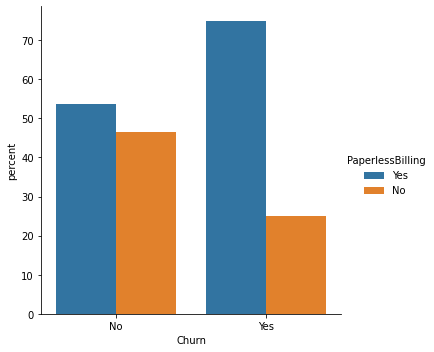

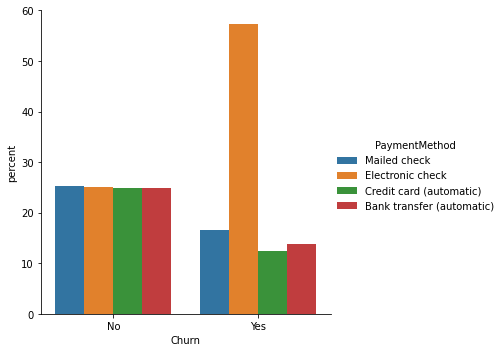

In [14]:
for col in cat_feature:
    x,y = 'Churn', col

    (df
    .groupby(x)[y]
    .value_counts(normalize=True)
    .mul(100)
    .rename('percent')
    .reset_index()
    .pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))

    plt.show()

**Key statistics**:
1. Single/no-partner customer dominates the churn customer set, reversely where customers with `Partner` dominates the non-churn customer set.
2. Customers that used `Fiber optic` as `InternetService` dominates (~70%) the churn customers, whereas it is not the case in non-churn customers i.e. more uniformly distributed; ~35% Fiber optic in non-churn customers.
3. ~80% of churn customers did not use `OnlineSecurity` on their InternetService. Additionaly, ~65% churn customers did not use `OnlineBackup`, ~63% did not use `DeviceProtection`
4. ~80% of churn customers did not use `TechSupport`.
5. ~85% of churn customers used `Month-to-month` contract.
6. ~60% of churn customers used `Electronic check` as `PaymentMethod`, whereas it is not the case in non-churn customers i.e. more uniformly distributed; ~25% Electronic check in non-churn customers

**Insights and Recommendations**:
1. There is a correlation between **security services** and **churn**. The statistics show that most churn customers did not use security/protection services (`OnlineSecurity`, `OnlineBackup` and `DeviceProtection`). It needs to be investigated why they did not use the security services; is it due their lack of awareness of security services, or lack of trust etc. Afterwards, we can launch campaign that increase awareness/trust on security services that might lead to decrease on the churn rate.
2. Majority of churn customers did not use `TechSupport`, which also might correlate #1 insight. It might probable that customers are only aware with security services or able to activate the security services once they talk to TechSupport. The onboarding process of security services might need to be relooked whether it is easy enough for the user to subscribe the security services without talking to TechSupport. *Alternatively*, we should look the problem in **wider** perspectives that some customers might be frustrated with the **general services**, not only security services. Instead of talking to TechSupport, they decided to churn instead. TechSupport might need to be made more accessible to the customers in order to reduce the churn rate.
3. Majority of churn customers used `Month-to-month` contract, which make them easier to terminate the contract at any time. We need to beware of the quality of our services since `One year` and `Two year` might also want to terminate the services once the contract ends and we need to retent them in our platform. Those who signed up with `Month-to-month` might have already intention to do trial with the services without committing long-term contract.

Connecting insights on `MonthlyCharges` with service selection, based on the data that we have, we learnt that actually churn customers use less number of services since most of them did not use security services. However, there is still one possible explanation that why churn customers ended up paying more due to their `InternetService` selection, whereas most of churn customers selected `Fiber optic`. Let's validate our hypothesis that `MonthlyCharges` differences came from InternetService selection.

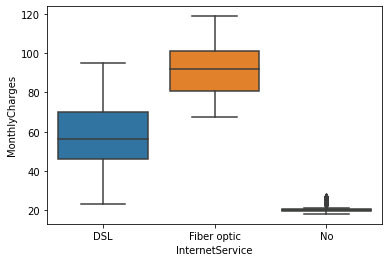

In [15]:
# Compare the MonthlyCharges between InternetService
sns.boxplot(x='InternetService',y='MonthlyCharges',data=df)

It is confirmed that `MonthlyCharges` differences came from `InternetService` selection since `Fiber optic` price is significantly higher compared to `DSL` and `No internet service`. This explains why churn customers ended up paying more `MonthlyCharges`. Then, it is logical to assess the quality and the pricing of of `Fiber optic` since it is our premium service, whether we give sufficient quality for the price that they pay, enough awareness and easy onboarding for security services etc.

## Data Cleansing

`TotalCharges` is stored as string. There are 11 rows stored TotalCharges that could not be casted as float and turned out they have missing values. I decided to remove those 11 rows since it is a small number and all of them are non-churn customers (majority class).

In [16]:
df[pd.to_numeric(df['TotalCharges'], errors='coerce').isna()][['TotalCharges','Churn']]

,TotalCharges,Churn
488,,No
753,,No
936,,No
1082,,No
1340,,No
3331,,No
3826,,No
4380,,No
5218,,No
6670,,No


In [17]:
# Cast TotalCharges as float
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [18]:
# Remove rows with missing TotalCharges
df = df[df.TotalCharges.notna()]

In [19]:
df.count()

customerID          7032
gender              7032
SeniorCitizen       7032
Partner             7032
Dependents          7032
tenure              7032
PhoneService        7032
MultipleLines       7032
InternetService     7032
OnlineSecurity      7032
OnlineBackup        7032
DeviceProtection    7032
TechSupport         7032
StreamingTV         7032
StreamingMovies     7032
Contract            7032
PaperlessBilling    7032
PaymentMethod       7032
MonthlyCharges      7032
TotalCharges        7032
Churn               7032
dtype: int64

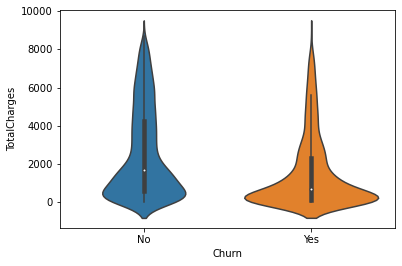

In [20]:
sns.violinplot(x='Churn',y='TotalCharges',data=df)
plt.show()

## Feature Engineering

In [21]:
def feat_engg(df):
    df['Churn'] = (df.Churn=='Yes')*1
    df['Female'] = (df.gender == 'Female')*1
    df['Partner'] = (df.Partner=='Yes')*1
    df['Dependents'] = (df.Dependents=='Yes')*1
    df['PhoneService'] = (df.PhoneService=='Yes')*1
    df['MultipleLines'] = (df.MultipleLines=='Yes')*1
    df = pd.concat([df, pd.get_dummies(df.InternetService, prefix='InternetService').drop('InternetService_No',axis=1)], axis=1)
    df['OnlineSecurity'] = (df.OnlineSecurity=='Yes')*1
    df['OnlineBackup'] = (df.OnlineBackup=='Yes')*1
    df['DeviceProtection'] = (df.DeviceProtection=='Yes')*1
    df['TechSupport'] = (df.TechSupport=='Yes')*1
    df['StreamingTV'] = (df.StreamingTV=='Yes')*1
    df['StreamingMovies'] = (df.StreamingMovies=='Yes')*1
    df = pd.concat([df, pd.get_dummies(df.Contract, prefix='Contract', drop_first=True)], axis=1)
    df['PaperlessBilling'] = (df.PaperlessBilling=='Yes')*1
    df = pd.concat([df, pd.get_dummies(df.PaymentMethod, prefix='PaymentMethod', drop_first=True)], axis=1)
    # Drop unnecessary columns
    df = df.drop(['customerID','gender','InternetService','Contract','PaymentMethod'],axis=1)
    return df
    

In [22]:
engg_df = feat_engg(df)

In [23]:
engg_df.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,TotalCharges,Churn,Female,InternetService_DSL,InternetService_Fiber optic,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,0,0,0,1,0,0,...,29.85,0,1,1,0,0,0,0,1,0
1,0,0,0,34,1,0,1,0,1,0,...,1889.50,0,0,1,0,1,0,0,0,1
2,0,0,0,2,1,0,1,1,0,0,...,108.15,1,0,1,0,0,0,0,0,1
3,0,0,0,45,0,0,1,0,1,1,...,1840.75,0,0,1,0,1,0,0,0,0
4,0,0,0,2,1,0,0,0,0,0,...,151.65,1,1,0,1,0,0,0,1,0


## Split Training and Test Set

In [24]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(engg_df, test_size=0.30, random_state=42)

In [25]:
train.Churn.value_counts()

0    3614
1    1308
Name: Churn, dtype: int64

In [26]:
test.Churn.value_counts()

0    1549
1     561
Name: Churn, dtype: int64

In [27]:
# Sanity check to ensure base rate between train and test are similar
print(len(train[train.Churn==1])/len(train))
print(len(test[test.Churn==1])/len(test))

0.2657456318569687
0.26587677725118486


Base rate is similar.

## Plot Features Correlation

In [28]:
# Feature correlation with target
train.corr()['Churn'].sort_values(ascending=False)

Churn                                    1.000000
InternetService_Fiber optic              0.319334
PaymentMethod_Electronic check           0.291697
MonthlyCharges                           0.201495
PaperlessBilling                         0.178155
SeniorCitizen                            0.155861
StreamingTV                              0.065352
StreamingMovies                          0.063472
MultipleLines                            0.041077
PhoneService                             0.018344
Female                                   0.013879
DeviceProtection                        -0.061407
OnlineBackup                            -0.073844
PaymentMethod_Mailed check              -0.092849
InternetService_DSL                     -0.134018
Partner                                 -0.139942
PaymentMethod_Credit card (automatic)   -0.140054
TechSupport                             -0.166938
Dependents                              -0.170629
OnlineSecurity                          -0.170993


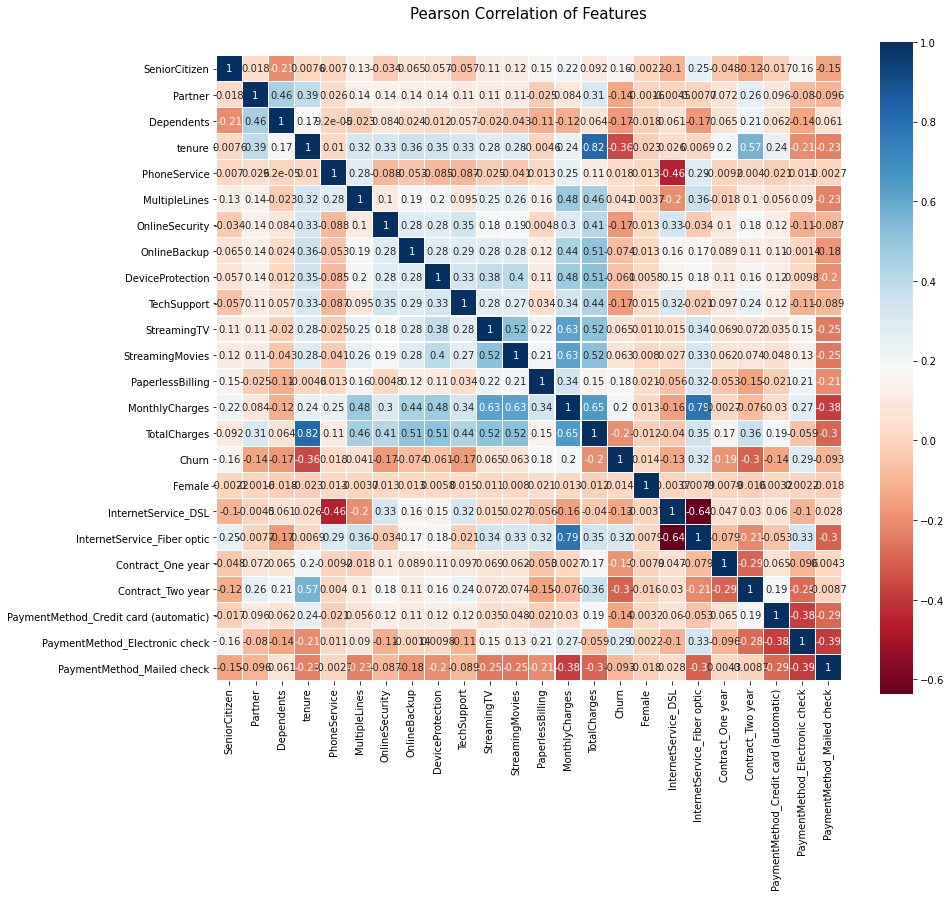

In [29]:
# Draw correlation heatmap
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

No striking high correlated features, hence no further feature selection is required.

## Model Selection

In [30]:
X = train.drop('Churn',axis=1)
y = train.Churn

In [31]:
roc = {}

In [32]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)
scores = cross_val_score(rfc,X,y,cv=5, n_jobs=-1, scoring='roc_auc')
roc['RandomForest'] = np.mean(np.array(scores))

In [33]:
# SVC
from sklearn.svm import SVC

svc = SVC(random_state=42)
scores = cross_val_score(svc,X,y,cv=5, n_jobs=-1, scoring='roc_auc')
roc['SVC'] = np.mean(np.array(scores))

In [34]:
# Xgbclassifier
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=42)
scores = cross_val_score(xgb,X,y,cv=5, n_jobs=-1, scoring='roc_auc')
roc['XGBClassifier'] = np.mean(np.array(scores))

In [35]:
# LightGBM
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(random_state=42)
scores = cross_val_score(lgbm,X,y,cv=5, n_jobs=-1, scoring='roc_auc')
roc['LightGBM'] = np.mean(np.array(scores))

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42)
scores = cross_val_score(lr,X,y,cv=5, n_jobs=-1, scoring='roc_auc') 
roc['LogisticRegression'] = np.mean(np.array(scores))

In [ ]:
# KNeighborClassifier

from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier()
scores = cross_val_score(knc,X,y,cv=5, n_jobs=-1, scoring='roc_auc')
roc['KNeighborClassifier'] = np.mean(np.array(scores))

In [ ]:
pd.DataFrame.from_dict(roc,orient='index', columns=['ROC score']).sort_values(by='ROC score', ascending=False)

It turns out **Logistic Regression** is the most performing model to perform the classification which achieves highest ROC score. Next, we will tune the hyperparameter for Logistic Regression

## Hyperparemeter finetuning

In [ ]:
from scipy.stats import loguniform

params = {
    'penalty':['l1','l2','elasticnet'],
    'C': loguniform(1e-3, 1000),
    'solver':['newton-cg', 'lbfgs', 'liblinear']
}

In [ ]:
model = RandomizedSearchCV(lr, params, random_state=42, n_iter=300, scoring='roc_auc', n_jobs=-1, cv=5, refit=True)

In [ ]:
# This process might take some time due to large number of iterations
search = model.fit(X, y)

In [ ]:
print(search.best_params_)
print(search.best_score_)

We have found the best hyperparameter for the model and turns out there is no significant gain compared to non-finetuned model. We will use this model to predict the hold-out test set.

In [ ]:
best_model = search.best_estimator_

In [ ]:
lr_coef = pd.DataFrame(best_model.coef_[0], index=X.columns.to_list(), columns=['coef'])
lr_coef.sort_values('coef', ascending=False)

## Predict Hold-out Test Set

In [ ]:
pred = best_model.predict(test.drop('Churn',axis=1))
print('accuracy: ',accuracy_score(test.Churn.values,pred))
print('confusion_matrix: ',plot_confusion_matrix(best_model,test.drop('Churn',axis=1),test.Churn.values))

We have ~80% accuracy classifier.